# Example data analysis

Execute the following command to run the simulation and generate the data files:
```bash
cd XeSim
make && $G4WORKDIR/bin/Linux-g++/XeSim -d template -p ./macros/template/preinit.mac -c ./macros/template/det_setup.mac -f ./macros/template/src_neutron.mac -n 10000
```

In [40]:
from particle import Particle
import dask_awkward as da
import dask.dataframe as dd
import awkward as ak
import numpy as np
import uproot
import hist
import glob
import dask

import matplotlib.pyplot as plt

## Read meta data

In [2]:
file = "../events.root"
rfile = uproot.open(file)

print(f"The file contains {len(rfile.keys())} keys:")
for key in rfile.keys():
    print(f"  {key}")

print(f"\nExecuted with G4VERSION {rfile['G4VERSION_TAG'].member('fTitle')}")
print(f"Total runtime: {rfile['G4RUNTIME'].member('fVal')} seconds")
print(f"Number of events: {rfile['events/nbevents'].member('fVal')}")

print(f"\nUsing the macros:")
for macro in rfile["macros"].keys():
    print(f"--> {rfile['macros'][macro].member('fName')}")
    print(f"    File content hidden for brevity ...")
    #for line in rfile["macros"][macro].member('fTitle').splitlines():
    #    print(f"    {line}")
    #print("")

The file contains 15 keys:
  G4VERSION_TAG;1
  MC_TAG;1
  MCVERSION_TAG;1
  macros;1
  macros/preinit.mac;1
  macros/det_setup.mac;1
  macros/src_neutron.mac;1
  tables;1
  tables/process_subtypes;1
  tables/logical_volumes;1
  tables/physical_volumes;1
  events;1
  events/nbevents;1
  events/events;1
  G4RUNTIME;1

Executed with G4VERSION $Name: geant4-10-06-patch-03 $
Total runtime: 2.108558178 seconds
Number of events: 1000

Using the macros:
--> preinit.mac
    File content hidden for brevity ...
--> det_setup.mac
    File content hidden for brevity ...
--> src_neutron.mac
    File content hidden for brevity ...


In [3]:
# Read tables for types and volumes
physical_volumes = {}
for k,v in zip(*rfile["tables/physical_volumes"].arrays(library="np", how=list)):
    physical_volumes = {**physical_volumes, **{k: v for k, v in zip(k, v)}}

print(f"\nPhysical volumes: {physical_volumes.keys()}")

def get_volume_name(volume_id):
    """Get the volume name from the volume ID."""
    _hashes = {v:k for k,v in physical_volumes.items()}
    if volume_id in _hashes:
        return _hashes[volume_id]
    else:
        return f"Unknown volume ID {volume_id}"

subtypes_table = rfile["tables/process_subtypes"].arrays(library="np")

particle_ids = {}
for k,v in zip(subtypes_table['particle_id'], subtypes_table['particle_name']):
    particle_ids = {**particle_ids, **{k: v for k, v in zip(k, v)}}

def get_particle_name(particle_id):
    """Get the particle name from the particle PDG code."""
    if particle_id in particle_ids:
        return particle_ids[particle_id]
    else:
        try:
            particle = Particle.from_pdgid(particle_id)
            return particle.name
        except Exception as e:
            return f"Unknown particle code {particle_id}"

print(f"Particle PDG code of 2112 is {get_particle_name(2112)}.")

process_subtype = {}
for k,v in zip(subtypes_table['process_subtype'], subtypes_table['process_name']):
    process_subtype = {**process_subtype, **{k: v for k, v in zip(k, v)}}

def get_process_name(process_id):
    """Get the process name from the process ID."""
    if process_id in process_subtype:
        return process_subtype[process_id]
    else:
        return f"Unknown process ID {process_id}"

print(f"Process type of 210 is {get_process_name(210)}.")


Physical volumes: dict_keys(['Lab', 'LXe', 'GXe', 'LXePTFECylinder', 'GXePTFECylinder', 'GXePTFETop', 'PmtPhotoCathode', 'LXePTFEBottom'])
Particle PDG code of 2112 is neutron.
Process type of 210 is RadioactiveDecayBase.


In [4]:
print(f"\nThe file contains {len(rfile['events/events'].keys())} TBranches in events/events:")
print(rfile['events/events'].keys())


The file contains 64 TBranches in events/events:
['eventid', 'type_pri', 'type_pri_id', 'e_pri', 'xp_pri', 'yp_pri', 'zp_pri', 'cx_pri', 'cy_pri', 'cz_pri', 'vol_pri', 'vol_pri_hash', 'photodethits', 'nphotodethits', 'etot', 'nsteps', 'trackid', 'parentid', 'type', 'typeid', 'parenttype', 'parenttypeid', 'creaproc', 'creaproctype', 'creaprocsubtype', 'edproc', 'edproctype', 'edprocsubtype', 'xp', 'yp', 'zp', 'ed', 'time', 'NSave', 'Save_flag', 'Save_desc', 'Save_type', 'Save_x', 'Save_y', 'Save_z', 'Save_cx', 'Save_cy', 'Save_cz', 'Save_e', 'Save_t', 'Save_eventid', 'Save_trackid', 'NNAct', 'NAct_eventid', 'NAct_trackid', 'NAct_parentid', 'NAct_t', 'NAct_volume', 'NAct_volume_hash', 'NAct_x', 'NAct_y', 'NAct_z', 'NAct_process_name', 'NAct_process_category', 'NAct_process_ID', 'NAct_particle_name', 'NAct_particle_atomicnumber', 'NAct_particle_mass', 'NAct_particle_excitationEnergy']


## Load small data files

In [5]:
file = "../events.root"

perEvent_keys = ["eventid", "*_pri*", 'etot', 'nsteps', "nphotodethits", 'NSave', 'NNAct']
perSensitiveHit_keys = ['trackid', 'parentid', 'type', 'typeid', 'parenttype', 'parenttypeid',
                        'creaproc', 'creaproctype', 'creaprocsubtype', 'edproc', 'edproctype', 'edprocsubtype',
                        'xp', 'yp', 'zp', 'ed', 'time']
perPhotonHit_keys = ["photodethit*"]
perSave_keys = ["Save_*"]
perNeutron_keys = ["NAct_*"]

def filter_columns(name, included_keys, excluded_keys):
    """Filter columns based on included and excluded keys."""
    matches_primary = any(uproot.interpretation.match.wildcard_match(name, key) for key in included_keys)
    is_excluded = any(excluded in name for excluded in excluded_keys)
    return matches_primary and not is_excluded

### Read primary particle data

In [6]:
primary_events = uproot.open(file+":events/events").arrays(filter_name=perEvent_keys)

# Remove string columns
primary_events = ak.without_field(primary_events, "vol_pri")
primary_events = ak.without_field(primary_events, "type_pri")

print(f"All primary types: {np.vectorize(get_particle_name)(np.unique(ak.ravel(primary_events['type_pri_id'])))}")
print(f"All primary volumes: {np.vectorize(get_volume_name)(np.unique(ak.ravel(primary_events['vol_pri_hash'])))}")

primary_events[0]

All primary types: ['neutron']
All primary volumes: ['Lab']


<Record {eventid: 0, type_pri_id: [2112], ...} type='{eventid: int32, type_...'>

In [7]:
sensitivevolume_events = uproot.open(file+":events/events").arrays(filter_name=perSensitiveHit_keys)

# Only sensitive events with entries nsteps > 0
sensitivevolume_events = sensitivevolume_events[ak.num(sensitivevolume_events['type']) > 0]

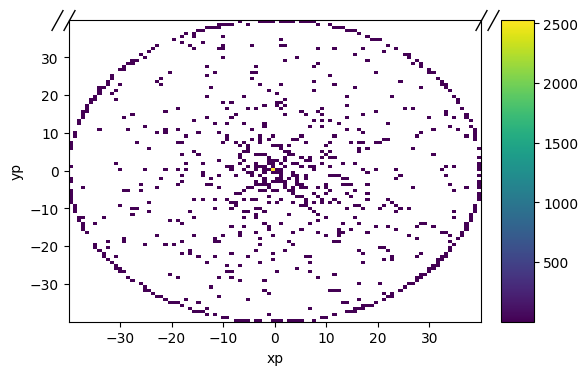

In [8]:
# Make a histogram of the xp_pri and yp_pri positions, infer ranges from the data
key_x, key_y = "xp", "yp"
data_x, data_y = ak.flatten(sensitivevolume_events[key_x], axis=-1), ak.flatten(sensitivevolume_events[key_y], axis=-1)
hist_2d = hist.Hist(hist.axis.Regular(100, ak.min(data_x), ak.max(data_x), name=key_x),
                    hist.axis.Regular(100, ak.min(data_y), ak.max(data_y), name=key_y))
hist_2d.fill(data_x, data_y)

fig, ax =  plt.subplots(dpi=100)
hist_2d.plot2d(ax=ax, cmin=1, cmap="viridis")
ax.set_xlabel(key_x)
ax.set_ylabel(key_y)
plt.show()


In [9]:
print(f"Found the following particle types in sensitive volume events:")
print(np.unique(ak.ravel(sensitivevolume_events['typeid'])))
print(np.vectorize(get_particle_name)(np.unique(ak.ravel(sensitivevolume_events['typeid']))))

Found the following particle types in sensitive volume events:
[-12, 2112, 1000541240, 1000541260, ..., 1000541320, 1000541340, 1000541360]
['anti_nu_e' 'neutron' 'Xe124' 'Xe126' 'Xe128' 'Xe129' 'Xe130' 'Xe131'
 'Xe132' 'Xe134' 'Xe136']


In [10]:
sensitivevolume_events[7].show()

{trackid: [1, 1, 3, 3, 2, 2],
 parentid: [0, 0, 1, 1, 1, 1],
 type: ['neutron', 'neutron', 'Xe136', 'Xe136', 'neutron', 'neutron'],
 typeid: [2112, 2112, 1000541360, 1000541360, 2112, 2112],
 parenttype: ['none', 'none', 'neutron', 'neutron', 'neutron', 'neutron'],
 parenttypeid: [0, 0, 2112, 2112, 2112, 2112],
 creaproc: ['Null', 'Null', ..., 'neutronInelastic', 'neutronInelastic'],
 creaproctype: [0, 0, 4, 4, 4, 4],
 creaprocsubtype: [0, 0, 121, 121, 121, 121],
 edproc: ['Transportation', 'neutronInelastic', ..., 'Transportation'],
 edproctype: [1, 4, 2, 2, 1, 1],
 edprocsubtype: [91, 121, 2, 22, 91, 91],
 xp: [0, 0, 2.9e-07, 2.9e-07, -7.25, -13.2],
 yp: [0, 0, -3.98e-07, -3.98e-07, 7.9, 14.4],
 zp: [0, -36.7, -36.7, -36.7, 0, 30],
 ed: [0, 0, 97.2, 0, 0, 0],
 time: [6.49e-08, 6.61e-08, 6.61e-08, 6.61e-08, 6.81e-08, 6.96e-08]}


In [11]:
# Select any event where one of the particle types is Xe136
has_Xe136 = ak.any((sensitivevolume_events['typeid'] == int(Particle.from_name("Xe136").pdgid)), axis=1)
with_Xe136 = ak.mask(sensitivevolume_events, has_Xe136)

ak.drop_none(with_Xe136).show()

[{trackid: [1, 1, 3, 3, 2, 2], parentid: [0, 0, ..., 1], type: [...], ...},
 {trackid: [1, 1, 1, 2, 2], parentid: [0, 0, ..., 1, 1], type: [...], ...},
 {trackid: [1, 1, 6, 6, 4], parentid: [0, 0, ..., 1, 1], type: [...], ...},
 {trackid: [1, 1, 1, 1, 3, 3, 2, 2], parentid: [0, ..., 1], type: [...], ...},
 {trackid: [1, 1, 7, 7, 2, 2, 8, 8], parentid: [0, ..., 2], type: [...], ...},
 {trackid: [1, 1, 3, 3, 2, 2, 7, 7], parentid: [0, ..., 2], type: [...], ...},
 {trackid: [1, 1, 3, 3, 2, 2, 7, 7], parentid: [0, ..., 2], type: [...], ...},
 {trackid: [1, 1, 7, 7, ..., 2, 2, 8, 8], parentid: [0, ..., 2], ...},
 {trackid: [1, 1, 3, 3, 2], parentid: [0, 0, ..., 1, 1], type: [...], ...},
 {trackid: [1, 1, 3, 3, 2], parentid: [0, 0, ..., 1, 1], type: [...], ...},
 ...,
 {trackid: [1, 1, 3, 3, 2, 2, 5, 5], parentid: [0, ..., 2], type: [...], ...},
 {trackid: [1, 1, 3, 3, 2], parentid: [0, 0, ..., 1, 1], type: [...], ...},
 {trackid: [1, 1, 5, 5, 4], parentid: [0, 0, ..., 1, 1], type: [...], ..

In [12]:
# Select any entry where the particle type is Xe136
has_Xe136 = sensitivevolume_events['typeid'] == int(Particle.from_name("Xe136").pdgid)
only_Xe136 = sensitivevolume_events[has_Xe136]
only_Xe136 = only_Xe136[ak.num(only_Xe136['type']) > 0]
only_Xe136.show()

[{trackid: [3, 3], parentid: [1, 1], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [2, 2], parentid: [1, 1], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [6, 6], parentid: [1, 1], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [2, 2], parentid: [1, 1], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [8, 8], parentid: [2, 2], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [7, 7], parentid: [2, 2], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [3, 3], parentid: [1, 1], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [8, 8], parentid: [2, 2], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [3, 3], parentid: [1, 1], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [3, 3], parentid: [1, 1], type: ['Xe136', ...], typeid: [...], ...},
 ...,
 {trackid: [5, 5], parentid: [2, 2], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [3, 3], parentid: [1, 1], type: ['Xe136', ...], typeid: [...], ...},
 {trackid: [5, 5], parentid: [1, 1

In [13]:
only_Xe136[0].show()

{trackid: [3, 3],
 parentid: [1, 1],
 type: ['Xe136', 'Xe136'],
 typeid: [1000541360, 1000541360],
 parenttype: ['neutron', 'neutron'],
 parenttypeid: [2112, 2112],
 creaproc: ['neutronInelastic', 'neutronInelastic'],
 creaproctype: [4, 4],
 creaprocsubtype: [121, 121],
 edproc: ['ionIoni', 'Scintillation'],
 edproctype: [2, 2],
 edprocsubtype: [2, 22],
 xp: [2.9e-07, 2.9e-07],
 yp: [-3.98e-07, -3.98e-07],
 zp: [-36.7, -36.7],
 ed: [97.2, 0],
 time: [6.61e-08, 6.61e-08]}


## Using dask to read large data files

```bash
cd XeSim
make && $G4WORKDIR/bin/Linux-g++/XeSim -d template -p ./macros/template/preinit.mac -c ./macros/template/det_setup.mac -f ./macros/template/src_neutron.mac -n 100000 -o ./events_01.root
make && $G4WORKDIR/bin/Linux-g++/XeSim -d template -p ./macros/template/preinit.mac -c ./macros/template/det_setup.mac -f ./macros/template/src_neutron.mac -n 100000 -o ./events_02.root
```

It might be needed to downgrade dask in order to have dask-awkward compatibility
```bash
pip install dask==2024.12.1
```

In [29]:
files = [f+":events/events" for f in glob.glob("../events_*.root")]

da_perEvent = uproot.dask(files, filter_name=perEvent_keys, allow_missing=True, step_size="2GB")
print(da_perEvent.fields)
da_perNeutron = uproot.dask(files, filter_name=perNeutron_keys, allow_missing=True, step_size="2GB")
print(da_perNeutron.fields)

# Select only rows with entries
da_perEvent = da_perEvent[ak.num(da_perEvent["type_pri"]) > 0]
da_perNeutron = da_perNeutron[ak.num(da_perNeutron["NAct_eventid"]) > 0]

df_perEvent = da.to_dataframe(da_perEvent)
df_perNeutron = da.to_dataframe(da_perNeutron)

['eventid', 'type_pri', 'type_pri_id', 'e_pri', 'xp_pri', 'yp_pri', 'zp_pri', 'cx_pri', 'cy_pri', 'cz_pri', 'vol_pri', 'vol_pri_hash', 'nphotodethits', 'etot', 'nsteps', 'NSave', 'NNAct']
['NAct_eventid', 'NAct_trackid', 'NAct_parentid', 'NAct_t', 'NAct_volume', 'NAct_volume_hash', 'NAct_x', 'NAct_y', 'NAct_z', 'NAct_process_name', 'NAct_process_category', 'NAct_process_ID', 'NAct_particle_name', 'NAct_particle_id', 'NAct_particle_atomicnumber', 'NAct_particle_mass', 'NAct_particle_excitationEnergy']


In [30]:
df_perEvent.head(1)

,,eventid,type_pri,type_pri_id,e_pri,xp_pri,yp_pri,zp_pri,cx_pri,cy_pri,cz_pri,vol_pri,vol_pri_hash,nphotodethits,etot,nsteps,NSave,NNAct
entry,subentry,,,,,,,,,,,,,,,,,
0,0,0,neutron,2112,5000.0,0.0,0.0,2000.0,0.0,0.0,-1.0,Lab,13570866368149792461,0,0.0,2,1,0


In [31]:
df_perNeutron.head(1)

,,NAct_eventid,NAct_trackid,NAct_parentid,NAct_t,NAct_volume,NAct_volume_hash,NAct_x,NAct_y,NAct_z,NAct_process_name,NAct_process_category,NAct_process_ID,NAct_particle_name,NAct_particle_id,NAct_particle_atomicnumber,NAct_particle_mass,NAct_particle_excitationEnergy
entry,subentry,,,,,,,,,,,,,,,,,
0,0,124,3,1,63.876923,GXePTFETop,1218148521,0.0,0.0,32.288475,neutronInelastic,4,121,N16,1000070160,7,16,0.0


In [38]:
only_Xe136 = df_perNeutron[df_perNeutron['NAct_particle_id'] == int(Particle.from_name("Xe133").pdgid)]

# This is slow as it does all the computation .. its just to show here
print(f"Found {len(only_Xe136)} Xe133 events in the neutron activation data.")

only_Xe136.head(3)

Found 76 Xe133 events in the neutron activation data.


,,NAct_eventid,NAct_trackid,NAct_parentid,NAct_t,NAct_volume,NAct_volume_hash,NAct_x,NAct_y,NAct_z,NAct_process_name,NAct_process_category,NAct_process_ID,NAct_particle_name,NAct_particle_id,NAct_particle_atomicnumber,NAct_particle_mass,NAct_particle_excitationEnergy
entry,subentry,,,,,,,,,,,,,,,,,
17,1,1424,13,12,1.036814e+15,LXe,1395771475,-1.355187e+00,-2.422980e+00,-16.890884,RadioactiveDecayBase,6,210,Xe133,1000541330,54,133,0.0
21,1,1746,18,17,2.477050e+14,LXe,1395771475,1.951417e+01,8.057517e+00,-23.002563,RadioactiveDecayBase,6,210,Xe133,1000541330,54,133,0.0
72,1,5484,8,7,5.169267e+14,LXe,1395771475,-4.466002e-08,8.936062e-08,-33.403965,RadioactiveDecayBase,6,210,Xe133,1000541330,54,133,0.0


In [47]:
df_perNeutron.head(20)

NAct_eventid  NAct_trackid  NAct_parentid        NAct_t  \
entry subentry                                                            
0     0                  124             3              1  6.387692e+01   
      1                  124             6              3  1.524021e+10   
1     0                  145             5              1  6.678132e+01   
2     0                  216             4              1  6.646487e+01   
      1                  216             7              4  1.843429e+09   
3     0                  275             4              1  6.389338e+01   
      1                  275             7              4  2.639453e+10   
4     0                  290             6              1  6.382225e+01   
      1                  290             7              6  2.715805e+09   
5     0                  318             3              1  6.745937e+01   
      1                  318             4              3  1.189518e+10   
6     0                  504             5              1  6.372026e+01   
      1                  504             8              5  2.700578e+08   
7     0                  512             5              1  3.359023e+01   
8     0                  576             5              1  6.738057e+01   
      1                  576             6              5  1.189847e+09   
9     0                  676             6              1  6.393153e+01   
10    0                  706             4              1  6.751648e+01   
      1                  706             5              4  5.456708e+09   
11    0                  732             5              1  6.723886e+01   

                    NAct_volume  NAct_volume_hash     NAct_x     NAct_y  \
entry subentry                                                            
0     0              GXePTFETop        1218148521   0.000000   0.000000   
      1              GXePTFETop        4049834374   0.001437   0.000353   
1     0         LXePTFECylinder         355223444  18.921465 -40.644222   
2     0         GXePTFECylinder        3459823179 -37.477329 -18.170389   
      1         GXePTFECylinder         805824130 -37.477299 -18.170206   
3     0              GXePTFETop        1218148521   0.000000   0.000000   
      1              GXePTFETop        4049834374   0.001563  -0.000560   
4     0              GXePTFETop        1218148521   0.000000   0.000000   
      1              GXePTFETop        4049834374  -0.000560   0.000125   
5     0           LXePTFEBottom        1977747755   0.000000   0.000000   
      1           LXePTFEBottom        3800368702  -0.000685  -0.000968   
6     0              GXePTFETop        1218148521   0.000000   0.000000   
      1              GXePTFETop        4049834374   0.001256  -0.000055   
7     0                     Lab        1876764365   0.000000   0.000000   
8     0           LXePTFEBottom        1977747755   0.000000   0.000000   
      1           LXePTFEBottom        3800368702   0.000911   0.000605   
9     0              GXePTFETop        1218148521  -0.334560  -1.111758   
10    0           LXePTFEBottom        1977747755   0.000000   0.000000   
      1           LXePTFEBottom        3800368702  -0.000712   0.001471   
11    0         PmtPhotoCathode        1332239327   0.000000   0.000000   

                    NAct_z     NAct_process_name  NAct_process_category  \
entry subentry                                                            
0     0          32.288475      neutronInelastic                      4   
      1          32.287537  RadioactiveDecayBase                      6   
1     0         -33.227680      neutronInelastic                      4   
2     0          20.298796      neutronInelastic                      4   
      1          20.298571  RadioactiveDecayBase                      6   
3     0          31.781654      neutronInelastic                      4   
      1          31.780615  RadioactiveDecayBase                      6   
4     0          33.972782      neutron

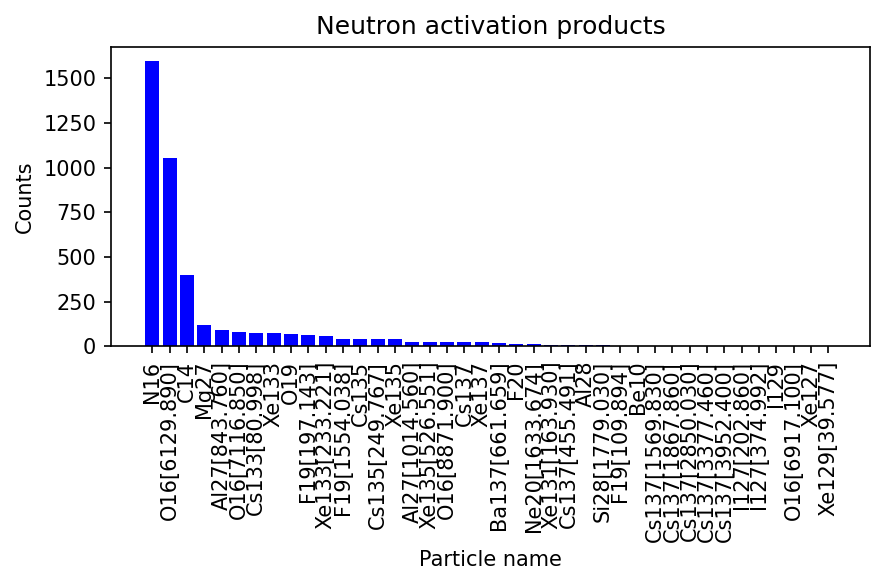

In [59]:
_counts = df_perNeutron['NAct_particle_name'].value_counts().compute()

dict_particle_counts = {p:c for p,c in zip(_counts.index, _counts.values)}

plt.figure(dpi=150)
plt.bar(dict_particle_counts.keys(), dict_particle_counts.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel("Particle name")
plt.ylabel("Counts")
plt.title("Neutron activation products")
plt.tight_layout()
plt.show()